In [2]:
import iris
import os
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
import xarray as xr
import gzip
import dask
import gzip
import shutil
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

from met_functions import *

# Open a datafile

In [2]:
# opening the file for 09/01/2020, world region 2 (europe),variable set _I_
filepath = "/gws/nopw/j04/name/met_archive/Global/UMG_Mk10PT/"
filename = "MO202001091800.UMG_Mk10_I_L59PT2.pp"

In [3]:
cube_list = iris.load(filepath + filename, callback=remove_coord_callback)

/opt/jaspy/lib/python3.11/site-packages/iris/fileformats/rules.py:340: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(


In [16]:
# file is a list of data "cubes", (lat, lon, height)
# the coordinates are mostly the same across cubes, but not always for some reason (more later)
cube_list

[<iris 'Cube' of m01s03i026 / (unknown) (latitude: 588; longitude: 642)>,
<iris 'Cube' of m01s03i319 / (unknown) (pseudo_level: 5; latitude: 588; longitude: 642)>,
<iris 'Cube' of Canopy water on tiles / (kg/m^2) (latitude: 588; longitude: 642)>,
<iris 'Cube' of m01s03i462 / (unknown) (latitude: 588; longitude: 642)>,
<iris 'Cube' of atmosphere_downward_eastward_stress / (Pa) (latitude: 588; longitude: 642)>,
<iris 'Cube' of atmosphere_downward_northward_stress / (Pa) (latitude: 589; longitude: 642)>,
<iris 'Cube' of air_pressure / (Pa) (model_level_number: 59; latitude: 588; longitude: 642)>,
<iris 'Cube' of air_pressure_at_sea_level / (Pa) (latitude: 588; longitude: 642)>,
<iris 'Cube' of air_temperature / (K) (latitude: 588; longitude: 642)>,
<iris 'Cube' of air_temperature / (K) (model_level_number: 59; latitude: 588; longitude: 642)>,
<iris 'Cube' of atmosphere_boundary_layer_thickness / (m) (latitude: 588; longitude: 642)>,
<iris 'Cube' of moisture_content_of_soil_layer / (kg m-2) (depth: 4; latitude: 588; longitude: 642)>,
<iris 'Cube' of specific_humidity / (kg kg-1) (model_level_number: 59; latitude: 588; longitude: 642)>,
<iris 'Cube' of surface_air_pressure / (Pa) (latitude: 588; longitude: 642)>,
<iris 'Cube' of surface_upward_sensible_heat_flux / (W m-2) (latitude: 588; longitude: 642)>,
<iris 'Cube' of upward_air_velocity / (m s-1) (model_level_number: 59; latitude: 588; longitude: 642)>,
<iris 'Cube' of x_wind / (m s-1) (model_level_number: 59; latitude: 588; longitude: 642)>,
<iris 'Cube' of y_wind / (m s-1) (model_level_number: 59; latitude: 589; longitude: 642)>]

In [18]:
# we can extract a single variable and transform it into an iris array
surface_pressure = xr.DataArray.from_iris(cube_list[13])
surface_pressure

<xarray.DataArray 'surface_air_pressure' (latitude: 588, longitude: 642)> Size: 2MB
dask.array<filled, shape=(588, 642), dtype=float32, chunksize=(588, 642), chunktype=numpy.ndarray>
Coordinates:
  * latitude                 (latitude) float32 2kB 24.98 25.08 ... 79.92 80.02
  * longitude                (longitude) float32 3kB 314.9 315.1 ... 404.9 405.1
    forecast_period          timedelta64[ns] 8B ...
    forecast_reference_time  datetime64[ns] 8B ...
    time                     datetime64[ns] 8B ...
Attributes:
    standard_name:  surface_air_pressure
    units:          Pa
    source:         Data from Met Office Unified Model
    STASH:          m01s00i409

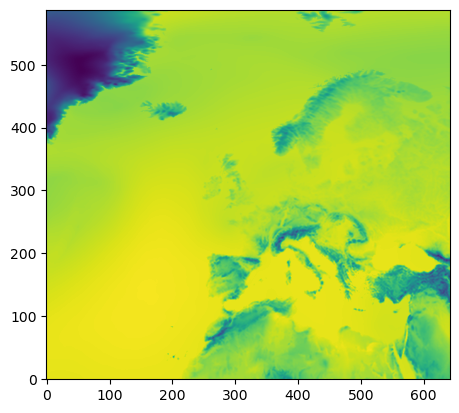

In [19]:
plt.imshow(surface_pressure.values, origin="lower")

## extracting a domain

In [4]:
region_bounds = get_saved_region_bounds()

In [5]:
region_bounds

{1: [79.921875, 89.953125, 0.0703125, -0.0703125],
 10: [-80.015625, -24.984375, -45.070312, 45.070312],
 11: [-80.015625, -24.984375, 44.929688, 135.07031],
 12: [-80.015625, -24.984375, 134.92969, -134.92969],
 13: [-80.015625, -24.984375, -135.07031, -44.929688],
 14: [-89.953125, -79.921875, 0.0703125, -0.0703125],
 2: [24.984375, 80.015625, -45.070312, 45.070312],
 3: [24.984375, 80.015625, 44.929688, 135.07031],
 4: [24.984375, 80.015625, 134.92969, -134.92969],
 5: [24.984375, 80.015625, -135.07031, -44.929688],
 6: [-25.078125, 25.078125, -45.070312, 45.070312],
 7: [-25.078125, 25.078125, 44.929688, 135.07031],
 8: [-25.078125, 25.078125, 134.92969, -134.92969],
 9: [-25.078125, 25.078125, -135.07031, -44.929688]}

In [6]:
# load a reference footprint to extract the domain for
fp_brazil = "/home/users/elenafi/satellite_met_scripts/GOSAT-BRAZIL-column_SOUTHAMERICA_201801.nc"
fp_india = "/home/users/elenafi/satellite_met_scripts/GOSAT-INDIA-SAM-column_SOUTHASIA_201503.nc"
fp_sahara = "/home/users/elenafi/satellite_met_scripts/GOSAT-SAHARA-column_NORTHAFRICA_201611.nc"

fp = xr.load_dataset(fp_brazil)

In [7]:
regions = find_overlapping_regions(fp.lat.values[0], fp.lat.values[-1], fp.lon.values[0], fp.lon.values[-1])
regions

[10, 13, 6, 9]

-60.981 22.323 -91.329 -24.801
10 [-80.015625, -24.984375, -45.070312, 45.070312]
13 [-80.015625, -24.984375, -135.07031, -44.929688]
6 [-25.078125, 25.078125, -45.070312, 45.070312]
9 [-25.078125, 25.078125, -135.07031, -44.929688]


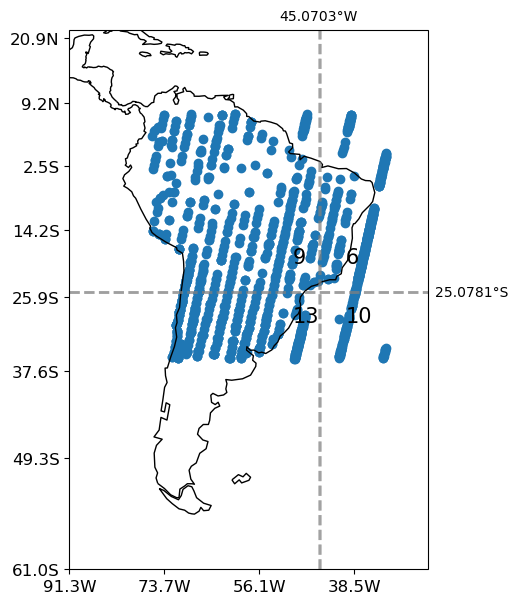

In [8]:
# plot observations and region domains
fig, ax = plt.subplots(1,1,figsize = (15,7), subplot_kw={'projection':cartopy.crs.Mercator()})
extent = [fp.lon.values[0], fp.lon.values[-1], fp.lat.values[0], fp.lat.values[-1]]

delta_lon = 0.352
delta_lat = 0.234

#extent = [fp.lon.values[0]-28*delta_lon, fp.lon.values[-1]+50*delta_lon, fp.lat.values[0]-80*delta_lat, fp.lat.values[-1]+50*delta_lat]
extent = [fp.lon.values[0], fp.lon.values[-1], fp.lat.values[0], fp.lat.values[-1]]
ax.scatter(fp.release_lon.values, fp.release_lat.values, transform=cartopy.crs.PlateCarree())
ax.coastlines()
ax.set_xticks(fp.lon.values[::50], crs=cartopy.crs.PlateCarree())
lon_formatter = LongitudeFormatter(number_format='.1f', degree_symbol='', dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)  
ax.set_yticks(fp.lat.values[::50], crs=cartopy.crs.PlateCarree())
lat_formatter = LatitudeFormatter(number_format='.1f',  degree_symbol='',)
ax.yaxis.set_major_formatter(lat_formatter)             
ax.tick_params(axis='both', which='major', labelsize=12)  
boundaries = np.array(list(region_bounds.values()))
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels  = False
gl.left_labels  = False
gl.xlocator = mticker.FixedLocator(list(set(boundaries[:,2]))+list(set(boundaries[:,3])))
gl.ylocator = mticker.FixedLocator(list(set(boundaries[:,0]))+list(set(boundaries[:,1])))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

## write the region numbers in the center corner
transformations = {(0,2):[5,5], (0,3):[5,-5], (1,2):[-5, 5], (1,3):[-5,-5]}
print(np.min(fp.lat.values), np.max(fp.lat.values), np.min(fp.lon.values), np.max(fp.lon.values))
for reg in regions:
    printed=False
    # print region number in region corners
    for la in [0,1]:
        for lo in [2,3]:
            if np.min(fp.lon.values) < region_bounds[reg][lo] < np.max(fp.lon.values) and np.min(fp.lat.values) < region_bounds[reg][la] < np.max(fp.lat.values):
                print(reg, region_bounds[reg])
                trans = transformations[(la, lo)]
                ax.text(region_bounds[reg][lo]+trans[1], region_bounds[reg][la]+trans[0], str(reg), fontsize=15, transform=cartopy.crs.PlateCarree())
                printed = True

#gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=2, color='blue', alpha=0.5, linestyle='--')
#gl.xlabels_top = False
#gl.ylabels_left = False
#gl.xlines = True
#gl.ylocator = mticker.FixedLocator([np.min(fp.release_lat)-100*delta_lat, np.max(fp.release_lat)+100*delta_lat])
#gl.xlocator = mticker.FixedLocator([np.min(fp.release_lon)-85*delta_lon, np.max(fp.release_lon)+100*delta_lon])

ax.set_extent(extent, crs=cartopy.crs.PlateCarree())

# intro to xarray - northafrica met problems?

In [3]:
# load_dataset loads a single file
fp_brazil = "/home/users/elenafi/satellite_met_scripts/GOSAT-BRAZIL-column_SOUTHAMERICA_201801.nc"

fp = xr.load_dataset(fp_brazil)

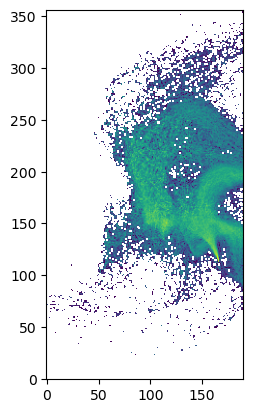

In [14]:
# plot the whole domain - footprints are better plotted logged!
# origin="lower" plots it the right way up (top is north, bottom is south, etc)
plt.imshow(np.log10(fp.fp[:,:,0]), origin="lower")

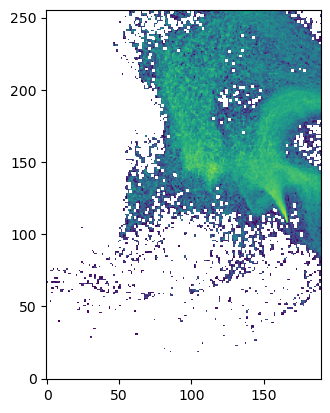

In [16]:
# or maybe we want to "slice" this, and plot only a particular section, eg the north
plt.imshow(np.log10(fp.sel(lat=slice(-60,0)).fp[:,:,0]), origin="lower")

In [9]:
# you can also load a list of files using , eg
met_files = sorted(glob.glob("/gws/nopw/j04/acrg/acrg/elenafi/satellite_met/NORTHAFRICA/NORTHAFRICA_Met_2015*.nc"))[:2]
print(met_files)
met = xr.open_mfdataset(met_files)

['/gws/nopw/j04/acrg/acrg/elenafi/satellite_met/NORTHAFRICA/NORTHAFRICA_Met_201501.nc', '/gws/nopw/j04/acrg/acrg/elenafi/satellite_met/NORTHAFRICA/NORTHAFRICA_Met_201502.nc']


In [17]:
met

<xarray.Dataset> Size: 37GB
Dimensions:                              (model_level_number: 20,
                                          latitude: 296, longitude: 320,
                                          time: 472)
Coordinates:
  * model_level_number                   (model_level_number) int32 80B 1 ... 57
  * time                                 (time) datetime64[ns] 4kB 2015-01-01...
    level_height                         (model_level_number) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
    sigma                                (model_level_number) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
  * latitude                             (latitude) float64 2kB -7.98 ... 61.05
  * longitude                            (longitude) float64 3kB -44.02 ... 6...
Data variables:
    air_pressure                         (model_level_number, latitude, longitude, time) float64 7GB dask.array<chunksize=(20, 296, 320, 248), meta=np.ndarray>
    air_pressure_at_sea_level            (latitude, longitude, time) float64 358MB dask.array<chunksize=(296, 320, 248), meta=np.ndarray>
    air_temperature                      (model_level_number, latitude, longitude, time) float64 7GB dask.array<chunksize=(20, 296, 320, 248), meta=np.ndarray>
    atmosphere_boundary_layer_thickness  (latitude, longitude, time) float64 358MB dask.array<chunksize=(296, 320, 248), meta=np.ndarray>
    surface_air_pressure                 (latitude, longitude, time) float64 358MB dask.array<chunksize=(296, 320, 248), meta=np.ndarray>
    upward_air_velocity                  (model_level_number, latitude, longitude, time) float64 7GB dask.array<chunksize=(20, 296, 320, 248), meta=np.ndarray>
    x_wind                               (model_level_number, latitude, longitude, time) float64 7GB dask.array<chunksize=(20, 296, 320, 248), meta=np.ndarray>
    y_wind                               (model_level_number, latitude, longitude, time) float64 7GB dask.array<chunksize=(20, 296, 320, 248), meta=np.ndarray>
Attributes:
    author:           Elena Fillola (ef17148)
    created:          2025-03-06 13:54
    transformations:  interpolated linearly in space to NAME resolution

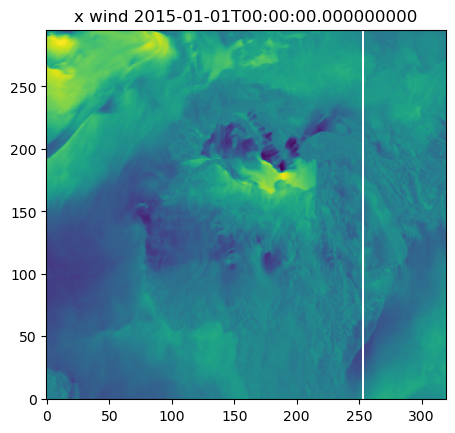

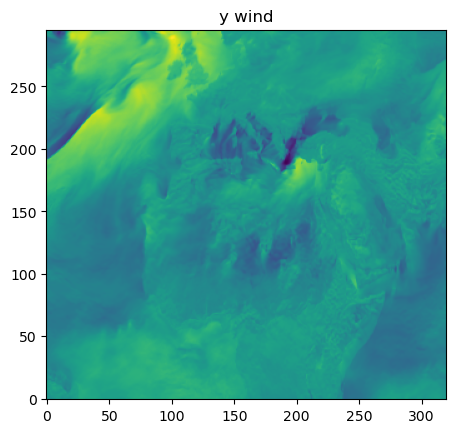

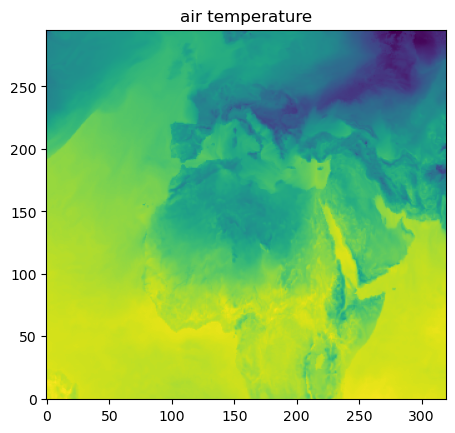

In [27]:
# currently there's an issue with these lines! only in the NorthAfrica files
# only in the wind variables, and only in some files
# some files have only xwind, some have both x and y
plt.imshow(met.sel(model_level_number=1, time=met.time.values[0]).x_wind.values, origin="lower")
plt.title(f"x wind {met.time.values[0]}")
plt.show()
plt.imshow(met.sel(model_level_number=1, time=met.time.values[0]).y_wind.values, origin="lower")
plt.title("y wind")
plt.show()
plt.imshow(met.sel(model_level_number=1, time=met.time.values[0]).air_temperature.values, origin="lower")
plt.title("air temperature")
plt.show()

In [33]:
met_weird_file = xr.open_dataset("/gws/nopw/j04/acrg/acrg/elenafi/satellite_met/NORTHAFRICA/NORTHAFRICA_Met_201403.nc")

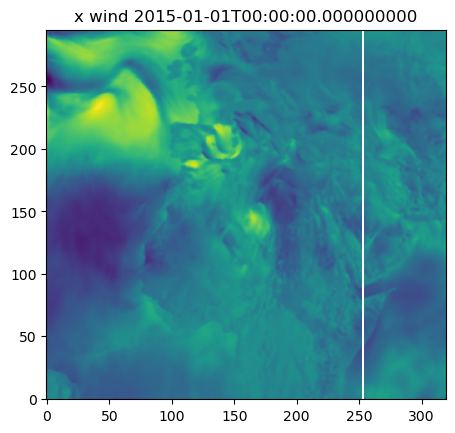

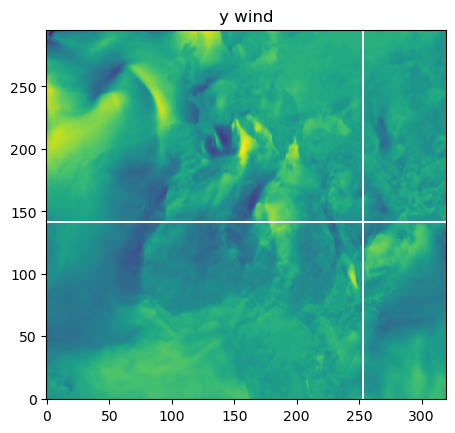

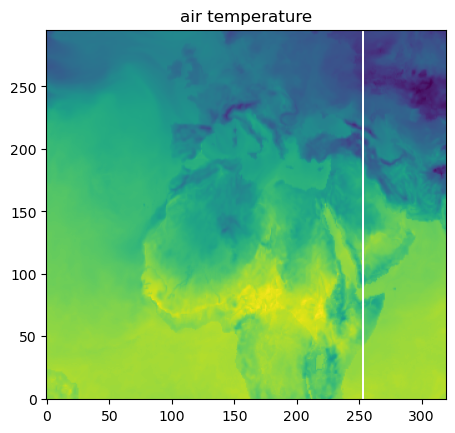

In [34]:
plt.imshow(met_weird_file.sel(model_level_number=1, time=met_weird_file.time.values[0]).x_wind.values, origin="lower")
plt.title(f"x wind {met.time.values[0]}")
plt.show()
plt.imshow(met_weird_file.sel(model_level_number=1, time=met_weird_file.time.values[0]).y_wind.values, origin="lower")
plt.title("y wind")
plt.show()
plt.imshow(met_weird_file.sel(model_level_number=1, time=met_weird_file.time.values[0]).air_temperature.values, origin="lower")
plt.title("air temperature")
plt.show()

In [ ]:
# ignore this for now
def drop_timevars(f):
    if "forecast_period" in f.coords:
        f = f.drop_vars(["forecast_period", "forecast_reference_time"])
    return f